In [1]:
import pickle
import pandas as pd
import spacy
import re
from time import time
import multiprocessing

# Embedding model trainings

### Embed company descriptions

#### Import Data

In [2]:
company_df = pd.read_csv("data/company_desc_translated.csv", sep=";")[["company_name", "description_en"]]

In [5]:
company_df

,company_name,description_en
0,Le Fourgon,Le Fourgon delivers your stored drinks to your...
1,Comptoir des Vignes,Comptoir des Vignes is a brand of cellars spec...
2,Shin Sekai,Welcome to our Trustpilot page! Shin Sekai is ...
3,Nutri Naturel,"Nutri-Naturel.com, the leading online organic ..."
4,Maison Martin - Le Piment Français,Maison Martin - Le Piment Francais is the firs...
...,...,...
12991,Ljbautoparts,"Sale of auto body spare parts online: fender, ..."
12992,Aéroports de Paris,"Aeroports de Paris, with its three platforms, ..."
12993,Online SAS,"Shared hosting with unlimited traffic, domain ..."
12994,shopequitation,Online specialist in the sale of horse riding ...


### Data Cleaning

In [6]:
nlp = spacy.load("en_core_web_sm") 

In [7]:
def cleaning(doc):
    # Lemmatizes and removes stopwords
    # doc needs to be a spacy Doc object
    txt = [token.lemma_ for token in doc if not token.is_stop and len(token.text) > 2]

    if len(txt) > 2:
        return ' '.join(txt)

In [8]:
brief_cleaning = (re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in company_df['description_en'])

In [1]:
txt = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=5000)]

NameError: name 'nlp' is not defined

In [ ]:
df_clean = pd.DataFrame({'clean': txt})
df_clean = df_clean.dropna().drop_duplicates()
df_clean.shape

(11365, 1)

In [ ]:
df_clean

,clean
0,fourgon deliver store drink home order place l...
1,comptoir des vigne brand cellar specialize win...
2,welcome trustpilot page shin sekai online figu...
3,nutri naturel com lead online organic grocery ...
4,maison martin piment francais brand artisanal ...
...,...
12991,sale auto body spare part online fender bumper...
12992,aeroport paris platform major connection point...
12993,share host unlimited traffic domain dedicated ...
12994,online specialist sale horse ride equipment sa...


In [ ]:
df_clean.head(1).values

array([['fourgon deliver store drink home order place lefourgon com beers juice sodas water milk wine soup spirit deliver home free charge choose niche visit collect bottle return wash producer reuse zerodechet']],
      dtype=object)

There is a gensim.models.phrases module which lets you automatically detect phrases longer than one word, using collocation statistics. Using phrases, you can learn a word2vec model where “words” are actually multiword expressions, such as new_york_times or financial_crisis:

In [ ]:
from gensim.models.phrases import Phrases, Phraser

In [ ]:
sent = [row.split() for row in df_clean['clean']]

In [ ]:
phrases = Phrases(sent, min_count=30, progress_per=10000)

In [ ]:
bigram = Phraser(phrases)

In [ ]:
sentences = bigram[sent]

In [ ]:
sentences[0]

['fourgon',
 'deliver',
 'store',
 'drink',
 'home',
 'order',
 'place',
 'lefourgon',
 'com',
 'beers',
 'juice',
 'sodas',
 'water',
 'milk',
 'wine',
 'soup',
 'spirit',
 'deliver_home',
 'free_charge',
 'choose',
 'niche',
 'visit',
 'collect',
 'bottle',
 'return',
 'wash',
 'producer',
 'reuse',
 'zerodechet']

In [ ]:
from collections import defaultdict 

In [ ]:
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
len(word_freq)

26671

In [ ]:
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

['offer',
 'product',
 'service',
 'france',
 'find',
 'quality',
 'good',
 'brand',
 'online',
 'support']

In [ ]:
cores = multiprocessing.cpu_count() # Count the number of cores in a computer
cores

16

#### Word2Vec

In [ ]:
from gensim.models import Word2Vec

In [ ]:
w2v_model = Word2Vec(min_count=20,
                     window=2,
                     vector_size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

In [ ]:
w2v_model.build_vocab(sentences, progress_per=10000)

In [ ]:
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

(4256044, 11171640)

In [ ]:
similar_words = w2v_model.wv.most_similar(positive=["wine"])
for word, similarity in similar_words:
    print(f"{word}: {similarity}")

champagne: 0.8991050720214844
winegrower: 0.8598325252532959
whiskey: 0.8446640968322754
estate: 0.8392442464828491
cellar: 0.814251720905304
tasting: 0.7975624799728394
spirit: 0.7863063812255859
rum: 0.7761200666427612
terroir: 0.7523260116577148
vineyard: 0.7511751055717468


Save model

In [ ]:
w2v_model.save("models/w2v_company_desc_model")

#### Fasttext

In [28]:
from gensim.models import FastText

In [76]:
fasttext_model = FastText(min_count=20,
                     window=2,
                     vector_size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

In [77]:
fasttext_model.build_vocab(sentences, progress_per=10000)

In [78]:
fasttext_model.train(sentences, total_examples=fasttext_model.corpus_count, epochs=30, report_delay=1)

(4255208, 11171640)

In [79]:
# fasttext_model.save("models/fasttext_model")

In [80]:
similar_words = fasttext_model.wv.most_similar(positive=["manga"])
for word, similarity in similar_words:
    print(f"{word}: {similarity}")

comic_strip: 0.8754724264144897
pop: 0.8432741761207581
figurine: 0.8119937777519226
series: 0.7878826856613159
goody: 0.781938374042511
geek: 0.7767835855484009
pokemon: 0.7508001327514648
fan: 0.7203569412231445
video_game: 0.7177428007125854
games: 0.7049591541290283


#### GloVe Transfer Learning

Load the Glove Model

In [36]:
import gensim.downloader

In [37]:
print(list(gensim.downloader.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [38]:
glove_vectors = gensim.downloader.load('glove-wiki-gigaword-300')

[==================================================] 100.0% 376.1/376.1MB downloaded


In [81]:
glove_vectors.most_similar('product')

[('products', 0.78656005859375),
 ('brand', 0.5952008366584778),
 ('marketing', 0.574771523475647),
 ('sales', 0.5687329769134521),
 ('consumer', 0.5489877462387085),
 ('brands', 0.5295148491859436),
 ('growth', 0.5233907699584961),
 ('quality', 0.5170866847038269),
 ('manufacturers', 0.5161595940589905),
 ('components', 0.5161356925964355)]

Train a base Model we can get the Word2Vec trained previously

In [88]:
base_model = Word2Vec.load('models/w2v_company_desc_model')

Sanity check

In [89]:
similar_words = base_model.wv.most_similar(positive=["wine"])
for word, similarity in similar_words:
    print(f"{word}: {similarity}")

champagne: 0.8991050720214844
winegrower: 0.8598325252532959
whiskey: 0.8446640968322754
estate: 0.8392442464828491
cellar: 0.814251720905304
tasting: 0.7975624799728394
spirit: 0.7863063812255859
rum: 0.7761200666427612
terroir: 0.7523260116577148
vineyard: 0.7511751055717468


ADD GLOVE WEIGHTS AND RETRAIN

In [90]:
list(glove_vectors.key_to_index)

['the',
 ',',
 '.',
 'of',
 'to',
 'and',
 'in',
 'a',
 '"',
 "'s",
 'for',
 '-',
 'that',
 'on',
 'is',
 'was',
 'said',
 'with',
 'he',
 'as',
 'it',
 'by',
 'at',
 '(',
 ')',
 'from',
 'his',
 "''",
 '``',
 'an',
 'be',
 'has',
 'are',
 'have',
 'but',
 'were',
 'not',
 'this',
 'who',
 'they',
 'had',
 'i',
 'which',
 'will',
 'their',
 ':',
 'or',
 'its',
 'one',
 'after',
 'new',
 'been',
 'also',
 'we',
 'would',
 'two',
 'more',
 "'",
 'first',
 'about',
 'up',
 'when',
 'year',
 'there',
 'all',
 '--',
 'out',
 'she',
 'other',
 'people',
 "n't",
 'her',
 'percent',
 'than',
 'over',
 'into',
 'last',
 'some',
 'government',
 'time',
 '$',
 'you',
 'years',
 'if',
 'no',
 'world',
 'can',
 'three',
 'do',
 ';',
 'president',
 'only',
 'state',
 'million',
 'could',
 'us',
 'most',
 '_',
 'against',
 'u.s.',
 'so',
 'them',
 'what',
 'him',
 'united',
 'during',
 'before',
 'may',
 'since',
 'many',
 'while',
 'where',
 'states',
 'because',
 'now',
 'city',
 'made',
 'like',
 

In [91]:
# add GloVe's vocabulary & weights
base_model.build_vocab([list(glove_vectors.key_to_index)], update=True)

In [92]:
base_model.train(sentences, total_examples=base_model.corpus_count, epochs=30, report_delay=1)

(4255269, 11171640)

In [93]:
# base_model.save("models/glove_transfer")

Glove Transfer Learning Word2Vec

In [94]:
similar_words = base_model.wv.most_similar(positive=["product"])
for word, similarity in similar_words:
    print(f"{word}: {similarity}")

carefully_select: 0.7098268270492554
high_quality: 0.6965193748474121
select: 0.6357077360153198
price_ratio: 0.6296204924583435
cosmetic: 0.625531792640686
food: 0.6144930124282837
quality: 0.6068709492683411
food_supplement: 0.6001089215278625
good: 0.5946057438850403
rigorously: 0.5908784866333008


Word2Vec

In [95]:
similar_words = w2v_model.wv.most_similar(positive=["product"])
for word, similarity in similar_words:
    print(f"{word}: {similarity}")

high_quality: 0.7416884899139404
select: 0.7157984375953674
rigorously: 0.7122600674629211
carefully_select: 0.7035292983055115
wide_range: 0.6896675825119019
parapharmacy: 0.6809306740760803
competitive_price: 0.6808081269264221
price_ratio: 0.6790063977241516
selection: 0.6649231314659119
assortment: 0.6438655257225037


### Exploring the Models

Adapted the code from this kaggle: https://www.kaggle.com/code/pierremegret/gensim-word2vec-tutorial

#### Word2vec

In [68]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [85]:
def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 300), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)

    # gets list of most similar words
    close_words = model.wv.most_similar([word])

    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)

    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)

    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=19).fit_transform(arrays)

    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)

    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)

    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})

    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)
    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))

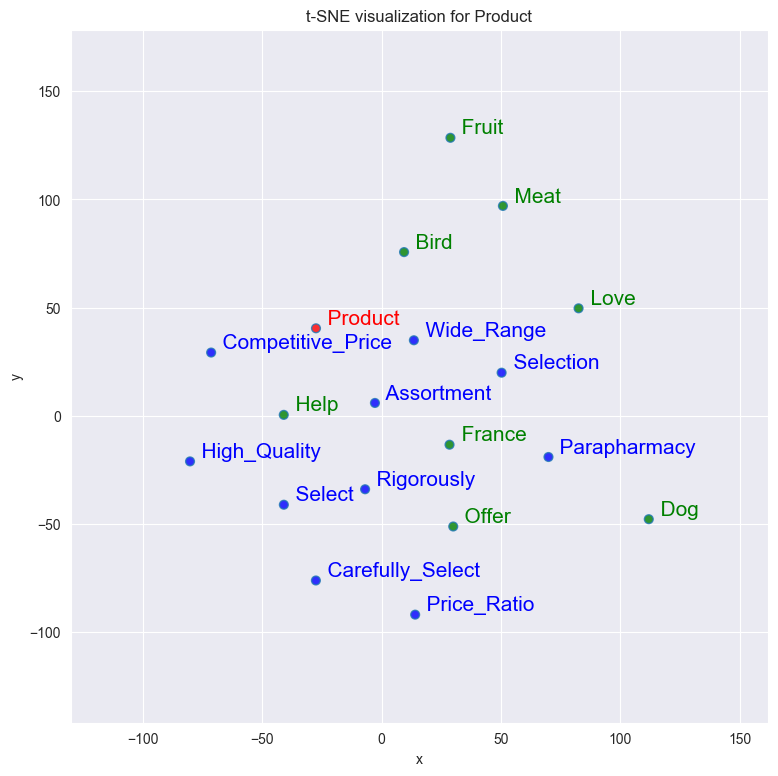

In [86]:
tsnescatterplot(w2v_model, 'product', ['dog', 'bird', 'offer', 'help', 'france', 'fruit', 'meat', 'love'])

#### FastText

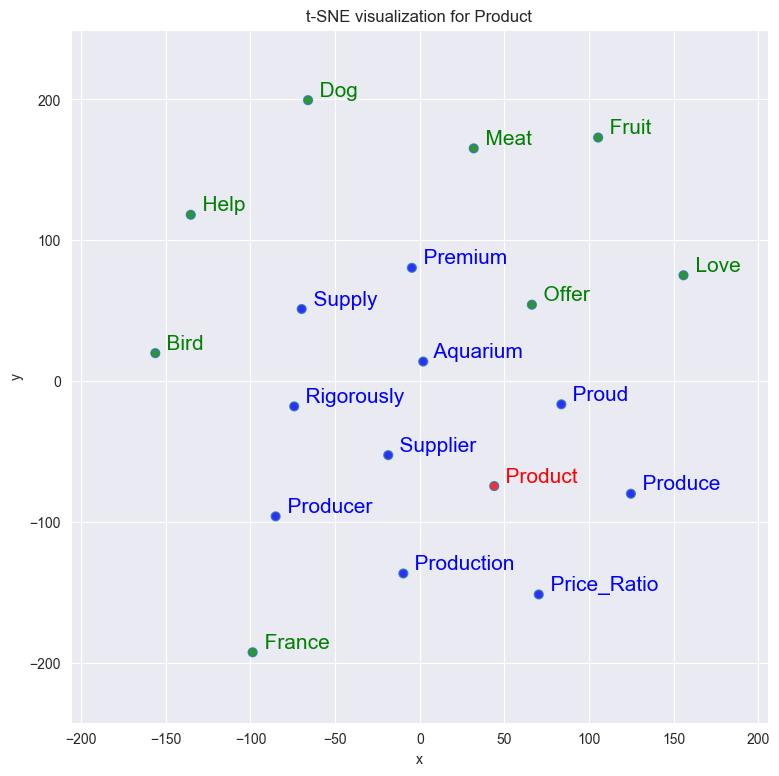

In [87]:
tsnescatterplot(fasttext_model, 'product', ['dog', 'bird', 'offer', 'help', 'france', 'fruit', 'meat', 'love'])

#### Glove Transfer Word2Vec Model

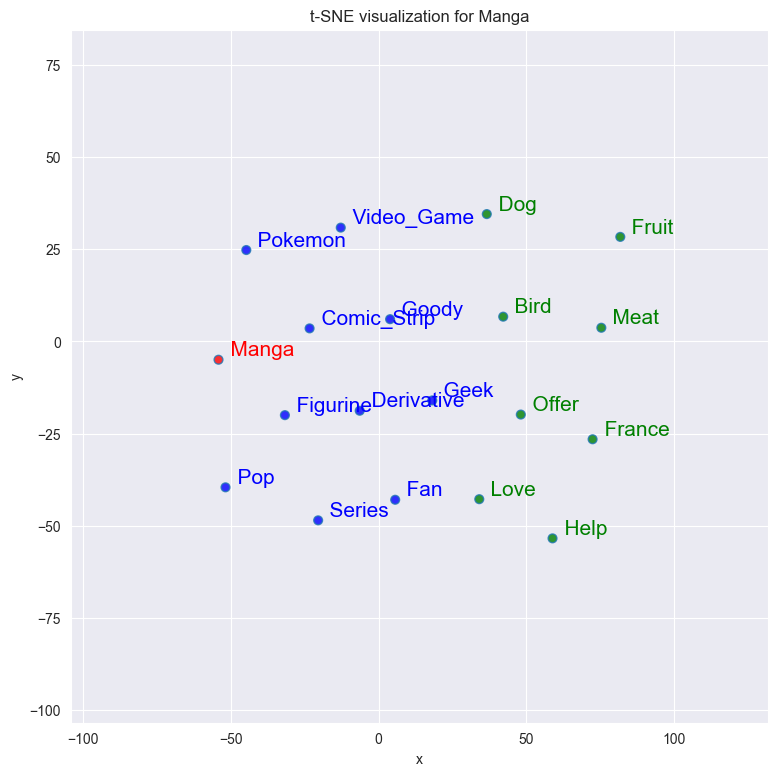

In [97]:
tsnescatterplot(base_model, 'manga', ['dog', 'bird', 'offer', 'help', 'france', 'fruit', 'meat', 'love'])